In [1]:
# 設定超參數HyperParameters 
batch_size =  128
epochs = 100
image_size = 128
lr=0.01

## 一、載入相關套件

In [2]:
import os
import cv2
import csv
import random
import time
import numpy as np
import pandas as pd
import matplotlib.image as mpimg # mpimg 用於讀取圖片
import matplotlib.pyplot as plt # plt 用於顯示圖片
import seaborn as sns


Bad key "text.kerning_factor" on line 4 in
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
import tensorflow as tf

from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import utils as np_utils
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, ZeroPadding2D, Dense, Activation, Conv2DTranspose

In [4]:
import tensorflow_datasets as tfds

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [6]:
# Print Start time
from datetime import datetime, timezone
import pytz

tpe = pytz.timezone('Asia/Taipei')
utc_start = datetime.now()
print("Start Time", tpe.fromutc(utc_start))

Start Time 2020-05-22 01:22:41.427854+08:00


## 製作標籤&資料集

In [7]:
def preProcess(ds):
    X = []
    y = []
    for ds_numpy in tfds.as_numpy(ds):
        res = tf.image.resize(ds_numpy['image'],(image_size,image_size),method='bilinear')
        X.append(res)
        y.append(ds_numpy['label'])
    X = tf.convert_to_tensor(X)
    y = np_utils.to_categorical(y)
    
    return X, y

In [8]:
# Build your input pipeline
train_ds = tfds.load("beans", split="train", shuffle_files=True)
valid_ds = tfds.load("beans", split="validation", shuffle_files=True)
test_ds = tfds.load("beans", split="test", shuffle_files=True)

In [9]:
x_train, y_train = preProcess(train_ds)
x_valid, y_valid = preProcess(valid_ds)
x_test, y_test = preProcess(test_ds)

In [10]:
x_test.shape

TensorShape([128, 128, 128, 3])

## 建立Model

In [11]:
# 建立深度學習CNN Model

model = tf.keras.Sequential()

model.add(layers.Conv2D(16,(3,3),
                 strides=(1,1),
                 input_shape=(image_size, image_size, 3),
                 padding='same',
                 activation='relu',
                 ))

model.add(layers.BatchNormalization())

model.add(layers.MaxPooling2D(pool_size=(2,2),strides=None))

model.add(layers.Conv2D(32,(3,3),
                 strides=(1,1),
                 padding='same',
                 activation='relu',
                 ))

model.add(layers.MaxPooling2D(pool_size=(2,2),strides=None))

model.add(layers.Conv2D(64,(3,3),
                 strides=(1,1),
                 padding='same',
                 activation='relu',
                 ))

model.add(layers.MaxPooling2D(pool_size=(2,2),strides=None))

model.add(layers.Flatten())

model.add(layers.Dense(64,activation='relu'))

model.add(layers.Dense(128,activation='relu'))


model.add(layers.Dropout(0.2))

model.add(layers.Dense(3,activation='softmax'))

In [12]:
adam = optimizers.Adam(lr=lr)
model.compile(optimizer=adam,
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['acc'])

In [13]:
# model.summary()

## 訓練

In [14]:
# zca_whitening 對輸入數據施加ZCA白化
# rotation_range 數據提升時圖片隨機轉動的角度
# width_shift_range 圖片寬度的某個比例，數據提升時圖片水平偏移的幅度
# shear_range 剪切強度（逆時針方向的剪切變換角度）
# zoom_range 隨機縮放的幅度
# horizontal_flip 進行隨機水平翻轉
# fill_mode ‘constant’，‘nearest’，‘reflect’或‘wrap’之一，當進行變換時超出邊界的點將根據本參數給定的方法進行處理

datagen = ImageDataGenerator(
    zca_whitening=False,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

In [15]:
# 檔名設定
file_name = str(epochs)+'_'+str(batch_size)

In [16]:
# 加入EarlyStopping以及Tensorboard等回調函數
CB = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
TB = keras.callbacks.TensorBoard(log_dir='./log'+"_"+file_name, histogram_freq=1)

In [17]:
### Start Training
history = model.fit(
    x = x_train , y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (x_valid, y_valid)
)

Epoch 1/100
9/9 [==============================] - 1s 129ms/step - loss: 10.9969 - acc: 0.3752 - val_loss: 9.4783 - val_acc: 0.3308
Epoch 2/100
9/9 [==============================] - 1s 67ms/step - loss: 0.9966 - acc: 0.4913 - val_loss: 3.7847 - val_acc: 0.4361
Epoch 3/100
9/9 [==============================] - 1s 67ms/step - loss: 0.9468 - acc: 0.5203 - val_loss: 5.7000 - val_acc: 0.3308
Epoch 4/100
9/9 [==============================] - 1s 66ms/step - loss: 0.8900 - acc: 0.5658 - val_loss: 1.0623 - val_acc: 0.4586
Epoch 5/100
9/9 [==============================] - 1s 68ms/step - loss: 0.8191 - acc: 0.5803 - val_loss: 1.2321 - val_acc: 0.5263
Epoch 6/100
9/9 [==============================] - 1s 68ms/step - loss: 0.7494 - acc: 0.6344 - val_loss: 1.9786 - val_acc: 0.5338
Epoch 7/100
9/9 [==============================] - 1s 67ms/step - loss: 0.7554 - acc: 0.6702 - val_loss: 1.3783 - val_acc: 0.4812
Epoch 8/100
9/9 [==============================] - 1s 67ms/step - loss: 0.6783 - acc: 0.

In [18]:
# Print Finish Training time
tpe = pytz.timezone('Asia/Taipei')
utc_finish = datetime.now()
print("Finish Training Time", tpe.fromutc(utc_finish))

difference = utc_finish-utc_start
seconds_in_day = 24 * 60 * 60
divmod(difference.days * seconds_in_day + difference.seconds, 60)

Finish Training Time 2020-05-22 01:23:57.048766+08:00


(1, 15)

## 繪製Model學習成效

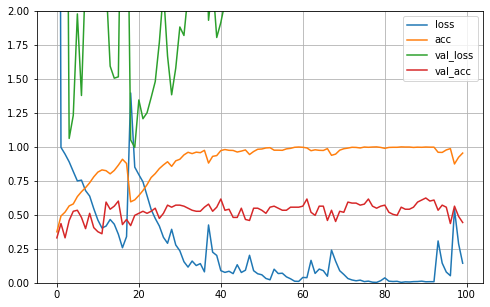

In [19]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,2)
    plt.show()
    
plot_learning_curves(history)

## 測試集預測準確度

In [20]:
# 測試集標籤預測
y_pred = model.predict(x_test)

In [21]:
# 模型預測後的標籤
predict_label = np.argmax(y_pred,axis=1)
print(predict_label)
# print(len(predict_label))

[0 1 2 2 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 2 0 2 2 0 0 1 0 1 2 0 1 1 0 0
 1 1 0 0 0 0 0 1 1 1 0 0 1 0 0 0 0 2 1 0 0 0 0 0 0 0 0 1 2 0 1 0 1 0 1 1 0
 0 1 1 2 0 0 0 0 1 0 0 1 1 0 0 0 0 1 2 0 0 0 1 2 1 0 2 2 0 1 1 1 0 0 0 0 0
 0 0 0 2 0 0 0 0 0 0 1 0 0 0 1 0 0]


In [22]:
# 模型原標籤
true_label = np.argmax(y_test, axis=1)
true_label = np.array(true_label)
print(true_label)
# print(len(true_label))

[1 0 2 1 0 1 1 0 0 1 0 1 1 2 2 2 0 2 1 1 1 0 2 2 2 2 0 1 1 2 1 2 2 1 1 1 1
 2 0 0 2 1 0 2 2 0 1 0 2 0 0 1 2 2 2 2 2 1 1 0 0 0 0 1 0 1 1 2 0 1 0 0 0 2
 1 2 0 0 2 2 2 0 1 2 0 0 2 1 2 0 0 1 1 1 1 1 0 2 1 1 2 2 0 1 1 2 0 1 0 0 0
 2 2 0 0 1 2 2 1 0 0 2 0 2 1 2 0 1]


In [23]:
pd.crosstab(true_label,predict_label,rownames=['實際值'],colnames=['預測值'])

預測值,0,1,2
實際值,,,
0,30,11,2
1,25,15,3
2,24,9,9


In [24]:
# 整體準確度
count = 0
for i in range(len(y_pred)):
    if(np.argmax(y_pred[i]) == np.argmax(y_test[i])): #argmax函数找到最大值的索引，即为其类别
        count += 1
score = count/len(y_pred)
print('正确率为:%.2f%s' % (score*100,'%'))

正确率为:42.19%
